---
# Severity Classification of Alzheimer's Disease Using MRI Images
## Jason Lu, Juan Marcucci, Dan Rossetti
---
---

# NOTEBOOK 2 - Manually-Built CNN Models

Notebook Summary:
This notebook contains a series of Convolutional Neural Network (CNN) models which have been employed to perform multi-class image classification.  A variety ot tehcniques are employed to improve model performance.

---
---

#  WARNING:  NOTEBOOK MUST BE RUN IN GOOGLE COLAB

Due to the computational demands of the convolutional neural networks used in this model requiring GPUs, this project was created entirely on Google Colab.

Further, the data are imported by cloning the Github repo where all of the project materials are stored into Google Colab so that the code can be run anywhere with the relative paths in this notebook.  With that, these relative paths will not work outside of Google Colab.

---
---

# 0 - Imports

In [ ]:
# Basic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Every method known to set random seeds (from the following sources):
# Help with this import:  https://www.tensorflow.org/tutorials/quickstart/advanced
import random
import tensorflow as tf
seed = 42
# Source provided by Eric Bayless for help with this:  
#  https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
tf.keras.utils.set_random_seed(seed)
random.seed(seed)
np.random.seed(seed)
# Help with code below from:  https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed)

# TensorFlow imports
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers

# Evaluation imports
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

# 1 - Connect to Github, Read Data
These are the same steps as perfomred in all other notebooks to gather the data.

As they have been previously established and commented, they are combined into a single cell for space and notebook readability.

In [ ]:
# Clear out the directory in case the code is re-run top to bottom.
!rm -r ga_project_4/

# Inspiration to do this from:  https://stackoverflow.com/questions/65386157/importing-images-from-github-to-colab
# Code help from:  https://neptune.ai/blog/google-colab-dealing-with-files
!git clone https://github.com/drossDS/ga_project_4.git

# Help with this code to cd into folders from:  
#  https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter
%cd ga_project_4/
%cd data/

# Unzip data
!unzip -q archive.zip

rm: cannot remove 'ga_project_4/': No such file or directory
Cloning into 'ga_project_4'...
remote: Enumerating objects: 6488, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 6488 (delta 23), reused 45 (delta 16), pack-reused 6424
Receiving objects: 100% (6488/6488), 157.10 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/ga_project_4
/content/ga_project_4/data


# 2 - Create Training and Validation Datasets, Import Testing Dataset
The code below is the same code used in notebooks 1 through 3 to import the data for multi-class classification


In [ ]:
# Create the training dataset using a 80/20 train/validation split
train_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/train',
    image_size = (208, 176),
    batch_size = 32,
    seed = 42,
    validation_split = 0.20,
    subset = 'training',
    label_mode = 'categorical',
)

val_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/train',
    image_size = (208, 176),
    batch_size = 32,
    seed = 42,
    validation_split = 0.20,
    subset = 'validation', 
    label_mode = 'categorical',
)

'''
The testing dataset will be imported in a similar manner, but
does not need to be batched or split.  So some of the arguments input
previously will not need to be called.

NOTE:  Below, 'shuffle' must be set to false.  It was discovered that every time
that test_ds is called (even just to extract the target values), different 
values were being provided each time that the extraction was run.  Turning
off shuffle (by setting it to false) proved effective in producing consistent
target values for the testing dataset.
'''
test_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/test',
    image_size = (208, 176),
    label_mode = 'categorical',
    seed = 42,
    shuffle = False
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


# 3 - Modeling - Manually-Built
This notebook contains entirely manually built (not pre-trained) models.

#### NOTE:
The models in this notebook are presented in their final configurations as it is not feasible to show all alterations to model parameters and laters.  Instead, general trends that were discovered during the model optimization process are discussed.

## Evaluation Metrics
The primary evaluation metric that will be used is the accuracy.  Aiming for a model with the best possible accuracy is an all-encompassing strategy to target model optimization and for model selection given that this is a multi-class classification model with a primary focus on prediction.

Clinically, the recall (sensitivity) for each class will also need to be examined, particularly for the Very Mild Dementia, Mild Dementia, and Moderate Dementia classes.  Recall will provide a good indication of how much of each class is being properly identified.  This is important when considering that the goal of this model in a medical setting would be to identify dementia so that treatement options can be prescribed.  If recall is low, that would mean that the demential class(es) is not being identified which may prevent patients from receiving treatment.

## 3.1 - Modeling Functions
Below, a variety of functions are created to perform repetetive tasks more efficiently in the code.


In [ ]:
'''
*** THIS FUNCTION IS REQUIRED TO COMPARE PREDICTED CLASSES TO TRUE CLASSES ***

Here a function is being defined which will extract and format the target data from the 
BatchDataset and then format it into an array of numbers that provide the class numbers.

It will optionally convert this to a pandas series for pandas operations (like .value_counts()).
'''

def target_extractor(data_array, series=False):

  # Source for help with the following line of code to extract classes:
  #  https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
  '''
  The list comprehension produces a list which is then turned into a numpy array with concatenate.  Note that
  an array of 1 x 4 arrays is created, with 4 probabilties of belonging to each class.
  '''
  y = np.concatenate([y for x, y in data_array], axis=0)
  
  '''
  The following argument takes the resulting array containing only probabilities of belonging
  to each class, determines which is the largest probability class, and replaces the entire
  1 x 4 array with a number corresponding to the highest probability class.  This soure was
  helpful wiht this:  
  https://stackoverflow.com/questions/68836551/keras-attributeerror-sequential-object-has-no-attribute-predict-classes
  '''
  y = np.argmax(y, axis = 1)

  # Make y a pandas array for when .value_counts needs to be called
  if series == True:
    y = pd.Series(y)

  return y

In [ ]:
'''
Create a funciton which will plot the final and best training and validation accuracies on a given model.
'''

def acc_printer(model):
  # Print the training and testing accuracies
  print(f"Final Model Accuracy on Training Data:  {model.history['acc'][-1]}")
  print(f"Final Model Accuracy on Validation Data:  {model.history['val_acc'][-1]}")

  print(f"Best Model Accuracy on Training Data:  {model.history['acc'][np.argmax(model.history['acc'])]}")
  print(f"Best Model Accuracy on Validation Data:  {model.history['val_acc'][np.argmax(model.history['val_acc'])]}")

In [ ]:
'''
Create a fucntion which plots confusion matrix and gives accuracy stats
'''

def results_plotter(input_model,
                    result_variable,
                    fig_name,
                    report = False):
  # Print the training and testing accuracies
  acc_printer(result_variable)

  # Get the model predictions
  preds = input_model.predict(test_ds, verbose = 0)

  # Convert the model predicitons into an array with class values
  preds_arr = np.argmax(preds, axis = 1)
  print(preds_arr.shape)
  preds_arr

  # Create a y_test array from test_ds that can be compared to the predictions
  y_test = target_extractor(test_ds)
  print(y_test.shape)
  y_test

  ConfusionMatrixDisplay.from_predictions(y_test, preds_arr)
  plt.title(f'{fig_name}', fontsize = 20)
  plt.xlabel('Predicted Label', size = 16)
  plt.ylabel('True Label', size = 16)
  # Help relabeling the axes from:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
  plt.xticks([0,1,2,3], ['mld', 'mod', 'none', 'vmld'])
  plt.yticks([0,1,2,3], ['mld', 'mod', 'none', 'vmld']);
  print(f'Model Accuracy on Test Data: {accuracy_score(y_test, preds_arr)} \n')
  plt.savefig(f'/content/ga_project_4/conf_matrix_{fig_name}.png')
  plt.show();

  if report == True:
    print(classification_report(y_test, preds_arr, target_names = ['mild', 'moderate', "none", 'very_mild']))

## 3.2 - Run Initial Convolutional Neural Network (CNN) Model

This is an initial convolutional neural network with very minimal minimal layers and additions.

In [ ]:
# Note:  This initial CNN is largely based on the models learned in the
#  CNN modeling lesson.

# Instantiate the sequential model
model = Sequential()

# Input later is needed for the model summary
model.add(layers.Input(shape=(208, 176, 3)))

# Rescaling layer - which basically divides everything by 255 to get
#  the values between 0 and 1
model.add(layers.Rescaling(1./255)) 

# Convolutional and pooling layer
model.add(Conv2D(64, (3,3), activation = 'relu')) # 'kernel' and 'filter' are synonymous
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional and pooling layer
model.add(Conv2D(64, (3,3), activation = 'relu')) # 'kernel' and 'filter' are synonymous
model.add(MaxPooling2D(pool_size=(2,2)))

# The above layers need to be flattened to a single dimension to be fed into
#  the dense layers below.
model.add(Flatten())

# First dense layer
model.add(Dense(64, activation='relu'))

# Output
model.add(Dense(4, activation = 'softmax'))

# Compile it
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Fit it
res_model = model.fit(train_ds,
               epochs = 10,
               batch_size = 64,
               validation_data = val_ds,
               verbose = 0)

Final Model Accuracy on Training Data:  1.0
Final Model Accuracy on Validation Data:  0.9794921875
Best Model Accuracy on Training Data:  1.0
Best Model Accuracy on Validation Data:  0.9794921875
(1279,)
(1279,)
Model Accuracy on Test Data: 0.5731039874902267 



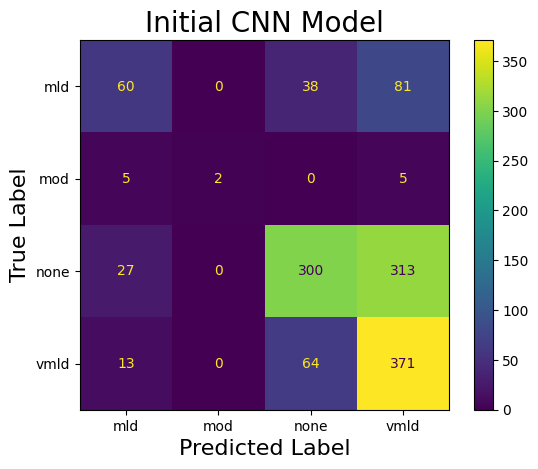

              precision    recall  f1-score   support

        mild       0.57      0.34      0.42       179
    moderate       1.00      0.17      0.29        12
        none       0.75      0.47      0.58       640
   very_mild       0.48      0.83      0.61       448

    accuracy                           0.57      1279
   macro avg       0.70      0.45      0.47      1279
weighted avg       0.63      0.57      0.56      1279



In [ ]:
# Plot results
results_plotter(model, res_model, fig_name = 'Initial CNN Model', report = True)

### Inital CNN Model OBSERVATIONS:
* The initial model has an accuracy of approcimately 57%
* The recall is highest for the Very Mild Dementia Class at 83%, and all other recall values are below 50%.  The class with the smallest number of samples has the lowest recall

# 3.3 Optimized CNN
The following model builds on the previous convolutional neural network model.

As stated previously, the optimization steps are not shown, as the tuning of this model was done by trial and error and showing the results of all such trials is not feasible.  The end of this section will note which changes to parameter values appear to have had what effect on the model.  

In [ ]:
# Instantiate the sequential model_a
model_a = Sequential()

# Early stopping
early_stopping = EarlyStopping(patience=10)

# Input layer and Rescaling
model_a.add(layers.Input(shape=(208, 176, 3)))
model_a.add(layers.Rescaling(1./255)) 

# Convolutional and pooling layer - 1
model_a.add(Conv2D(64, (3,3),
                 padding='same', 
                 activation = 'relu')) 
model_a.add(MaxPooling2D(pool_size=(2,2)))

# Batch Normalization layer
model_a.add(BatchNormalization())

# Convolutional and pooling layer
model_a.add(Conv2D(64, (3,3), 
                 padding='same',
                 activation = 'relu')) 
model_a.add(MaxPooling2D(pool_size=(2,2)))
model_a.add(BatchNormalization())

# Convolutional and pooling layer
model_a.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a.add(MaxPooling2D(pool_size=(2,2)))
model_a.add(BatchNormalization())

# Convlutional and pooling layers 4 - 7
model_a.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a.add(MaxPooling2D(pool_size=(2,2)))

model_a.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a.add(MaxPooling2D(pool_size=(2,2)))

model_a.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a.add(MaxPooling2D(pool_size=(2,2)))

model_a.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer
model_a.add(Flatten())

# Fully connected layer
model_a.add(Dense(64, activation='relu'))

# Batch normalization before output layer
model_a.add(BatchNormalization())

# Output layer
model_a.add(Dense(4, activation = 'softmax'))

# Compile model_a
model_a.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Fit model_a
res_model_a = model_a.fit(train_ds,
               epochs = 20,
               batch_size = 64,
               validation_data = val_ds,
               verbose = 1,
               callbacks=[early_stopping])

Epoch 1/20
129/129 [==============================] - 16s 66ms/step - loss: 1.0379 - acc: 0.5719 - val_loss: 1.2595 - val_acc: 0.5225
Epoch 2/20
129/129 [==============================] - 9s 72ms/step - loss: 0.6871 - acc: 0.7139 - val_loss: 1.9494 - val_acc: 0.3516
Epoch 3/20
129/129 [==============================] - 10s 74ms/step - loss: 0.4749 - acc: 0.8165 - val_loss: 5.4187 - val_acc: 0.5195
Epoch 4/20
129/129 [==============================] - 9s 67ms/step - loss: 0.2735 - acc: 0.9036 - val_loss: 4.0154 - val_acc: 0.7656
Epoch 5/20
129/129 [==============================] - 9s 65ms/step - loss: 0.1228 - acc: 0.9658 - val_loss: 4.4000 - val_acc: 0.3779
Epoch 6/20
129/129 [==============================] - 9s 66ms/step - loss: 0.0680 - acc: 0.9829 - val_loss: 4.8937 - val_acc: 0.4307
Epoch 7/20
129/129 [==============================] - 9s 67ms/step - loss: 0.0753 - acc: 0.9788 - val_loss: 2.0599 - val_acc: 0.5010
Epoch 8/20
129/129 [==============================] - 9s 68ms/step 

Final Model Accuracy on Training Data:  0.9997559189796448
Final Model Accuracy on Validation Data:  0.96875
Best Model Accuracy on Training Data:  0.9997559189796448
Best Model Accuracy on Validation Data:  0.96875
(1279,)
(1279,)
Model Accuracy on Test Data: 0.5269741985926505 



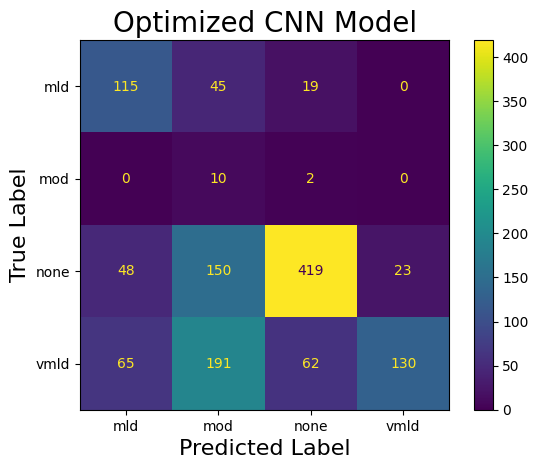

              precision    recall  f1-score   support

        mild       0.50      0.64      0.57       179
    moderate       0.03      0.83      0.05        12
        none       0.83      0.65      0.73       640
   very_mild       0.85      0.29      0.43       448

    accuracy                           0.53      1279
   macro avg       0.55      0.61      0.45      1279
weighted avg       0.79      0.53      0.60      1279



In [ ]:
# Plot results
results_plotter(model_a, res_model_a, fig_name = 'Optimized CNN Model', report = True)

### Optimized CNN OBSERVATIONS

#### Modeling
After running multiple iterations of the above model, the following observations have been made:
* Dropout layers (running between 0.25 and 0.5 probability) significantly reduce model performance, particularly in the convolutional layers
* Adding convolutional layers significantly improves model performance
* Using batch normalization layers after each convolutional layer has been found to have a drastically negative impact on model performance
* Max Pooling layers are reuqired when running many convolutional layers to prevent the notebook from crashing

#### Metrics:
* The optimized model has decreased overall performance with an accuracy of 53%
* Based on the recall values and confusion matrix, this model has more imbalanced performance

## 3.4 - Optimized CNN Model with Class Weights
This model will replicate the previous model in all aspects except that in the fit stage, class weights will be provided.  This wil attempt to even out the performance on classes.

In [ ]:
# Create a function which will determine the class weights based on the number
#  of samples in each class.

# https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99
from sklearn.utils.class_weight import compute_class_weight

def generate_class_weights(class_series):
  y = np.concatenate([y for x, y in class_series], axis=0)
  class_series = np.argmax(y, axis=1)
  class_labels = np.unique(class_series)
  class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
  return dict(zip(class_labels, class_weights))

class_weights = generate_class_weights(train_ds)
n_classes = len(class_weights)

In [ ]:
# Instantiate the sequential model_b
model_b = Sequential()

# Early stopping
early_stopping = EarlyStopping(patience=10)

# Input layer and Rescaling
model_b.add(layers.Input(shape=(208, 176, 3)))
model_b.add(layers.Rescaling(1./255)) 

# Convolutional and pooling layer - 1
model_b.add(Conv2D(64, (3,3), #was 128
                 padding='same', 
                 activation = 'relu')) 
model_b.add(MaxPooling2D(pool_size=(2,2)))

# Batch Normalization layer
model_b.add(BatchNormalization())

# Convolutional and pooling layer - 2
model_b.add(Conv2D(64, (3,3), 
                 padding='same', #was 256
                 activation = 'relu')) 
model_b.add(MaxPooling2D(pool_size=(2,2)))
model_b.add(BatchNormalization())

# Convolutional and pooling layer
model_b.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_b.add(MaxPooling2D(pool_size=(2,2)))
model_b.add(BatchNormalization())

# Convolutional and pooling layers 4-7
model_b.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_b.add(MaxPooling2D(pool_size=(2,2)))

model_b.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_b.add(MaxPooling2D(pool_size=(2,2)))

model_b.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_b.add(MaxPooling2D(pool_size=(2,2)))

model_b.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_b.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer
model_b.add(Flatten())

# Fully connected layer
model_b.add(Dense(64, activation='relu'))

# Batch Normalization layer
model_b.add(BatchNormalization())

# Output layer
model_b.add(Dense(4, activation = 'softmax'))

# Compile model_b
model_b.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Fit model_b
res_model_b = model_b.fit(train_ds,
               epochs = 20,
               class_weight = class_weights,
               batch_size = 64,
               validation_data = val_ds,
               verbose = 1,
               callbacks=[early_stopping])

Epoch 1/20
129/129 [==============================] - 14s 67ms/step - loss: 1.1261 - acc: 0.4403 - val_loss: 2.4727 - val_acc: 0.0879
Epoch 2/20
129/129 [==============================] - 8s 62ms/step - loss: 0.7648 - acc: 0.5870 - val_loss: 4.1301 - val_acc: 0.5195
Epoch 3/20
129/129 [==============================] - 8s 63ms/step - loss: 0.4873 - acc: 0.7125 - val_loss: 5.0072 - val_acc: 0.0469
Epoch 4/20
129/129 [==============================] - 8s 65ms/step - loss: 0.3476 - acc: 0.8116 - val_loss: 4.7855 - val_acc: 0.5215
Epoch 5/20
129/129 [==============================] - 8s 61ms/step - loss: 0.1930 - acc: 0.9011 - val_loss: 3.0511 - val_acc: 0.3740
Epoch 6/20
129/129 [==============================] - 8s 63ms/step - loss: 0.1162 - acc: 0.9436 - val_loss: 5.2502 - val_acc: 0.0791
Epoch 7/20
129/129 [==============================] - 8s 64ms/step - loss: 0.0578 - acc: 0.9783 - val_loss: 3.2816 - val_acc: 0.3584
Epoch 8/20
129/129 [==============================] - 8s 65ms/step -

Final Model Accuracy on Training Data:  0.9997559189796448
Final Model Accuracy on Validation Data:  0.98828125
Best Model Accuracy on Training Data:  0.9997559189796448
Best Model Accuracy on Validation Data:  0.98828125
(1279,)
(1279,)
Model Accuracy on Test Data: 0.6724003127443315 



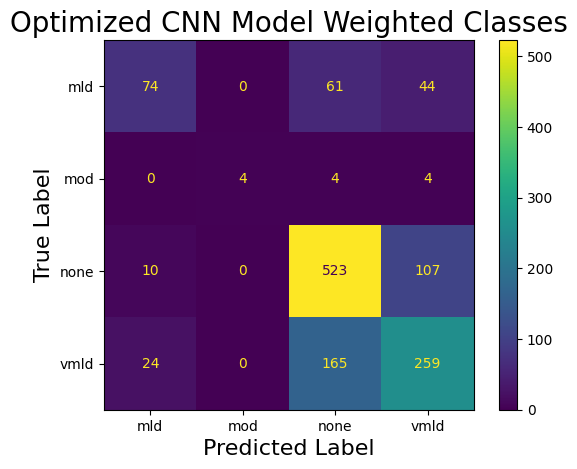

              precision    recall  f1-score   support

        mild       0.69      0.41      0.52       179
    moderate       1.00      0.33      0.50        12
        none       0.69      0.82      0.75       640
   very_mild       0.63      0.58      0.60       448

    accuracy                           0.67      1279
   macro avg       0.75      0.54      0.59      1279
weighted avg       0.67      0.67      0.66      1279



In [ ]:
# Plot results
results_plotter(model_b, res_model_b, fig_name = 'Optimized CNN Model Weighted Classes', report = True)

#### OBSERVATIONS:
Though the model optiized with class weights has an improved accuracy comapred to the previous model at 67%.  Generally speaking, the recall valus have improved in all classes

## 3.5 - Optimized CNN Model with Image Augmentation
It was previously observed that the images from the test dataset appear different than those of the training dataset.  WIth that, introducing variability in the images use to train the model may affect the performance. This model will use keras preprocessing techniques to alter images in the training set.

In [ ]:
# Instantiate model with iomage augmentation
#  Source helping wiht this:
#    https://keras.io/api/layers/preprocessing_layers/image_augmentation/
#    https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/
#    https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_rotation/
#    https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/
#    https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

model_c = Sequential([
    preprocessing.RandomRotation(0.4),
    preprocessing.RandomZoom(0.4),
    preprocessing.RandomFlip(mode='horizontal'),
])

# Early stopping
early_stopping = EarlyStopping(patience=10)

# Input layer
model_c.add(layers.Input(shape=(208, 176, 3)))
model_c.add(layers.Rescaling(1./255)) 

# Convolutional and pooling layer - 1
model_c.add(Conv2D(64, (3,3),
                 padding='same', 
                 activation = 'relu')) 
model_c.add(MaxPooling2D(pool_size=(2,2)))

# Batch Normalization layer
model_c.add(BatchNormalization())

# Convolutional and pooling layer
model_c.add(Conv2D(64, (3,3), 
                 padding='same',
                 activation = 'relu')) 
model_c.add(MaxPooling2D(pool_size=(2,2)))
model_c.add(BatchNormalization())

# Convolutional and pooling layer
model_c.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_c.add(MaxPooling2D(pool_size=(2,2)))
model_c.add(BatchNormalization())

# Convlutional and pooling layers 4 - 7
model_c.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_c.add(MaxPooling2D(pool_size=(2,2)))

model_c.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_c.add(MaxPooling2D(pool_size=(2,2)))

model_c.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_c.add(MaxPooling2D(pool_size=(2,2)))

model_c.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_c.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer
model_c.add(Flatten())

# Fully connected layer
model_c.add(Dense(64, activation='relu'))

# Batch normalization before output layer
model_c.add(BatchNormalization())

# Output layer
model_c.add(Dense(4, activation = 'softmax'))

# Compile model_c
model_c.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Fit model_c
res_model_c = model_c.fit(train_ds,
               epochs = 20,
               batch_size = 64,
               validation_data = val_ds,
               verbose = 1,
               callbacks=[early_stopping])

Epoch 1/20
129/129 [==============================] - 14s 69ms/step - loss: 1.1389 - acc: 0.4955 - val_loss: 1.1432 - val_acc: 0.5195
Epoch 2/20
129/129 [==============================] - 9s 69ms/step - loss: 0.9496 - acc: 0.5504 - val_loss: 1.3212 - val_acc: 0.5195
Epoch 3/20
129/129 [==============================] - 9s 65ms/step - loss: 0.9204 - acc: 0.5546 - val_loss: 1.8952 - val_acc: 0.5195
Epoch 4/20
129/129 [==============================] - 9s 67ms/step - loss: 0.9241 - acc: 0.5524 - val_loss: 1.5626 - val_acc: 0.5195
Epoch 5/20
129/129 [==============================] - 9s 67ms/step - loss: 0.9124 - acc: 0.5563 - val_loss: 1.1254 - val_acc: 0.5205
Epoch 6/20
129/129 [==============================] - 9s 69ms/step - loss: 0.9057 - acc: 0.5543 - val_loss: 0.8898 - val_acc: 0.5430
Epoch 7/20
129/129 [==============================] - 9s 68ms/step - loss: 0.9103 - acc: 0.5460 - val_loss: 0.9528 - val_acc: 0.5488
Epoch 8/20
129/129 [==============================] - 9s 67ms/step -

Final Model Accuracy on Training Data:  0.5670002698898315
Final Model Accuracy on Validation Data:  0.5595703125
Best Model Accuracy on Training Data:  0.5711496472358704
Best Model Accuracy on Validation Data:  0.568359375
(1279,)
(1279,)
Model Accuracy on Test Data: 0.5222830336200156 



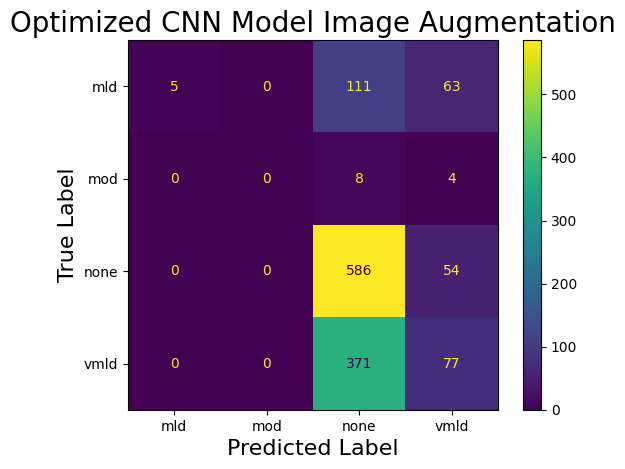

              precision    recall  f1-score   support

        mild       1.00      0.03      0.05       179
    moderate       0.00      0.00      0.00        12
        none       0.54      0.92      0.68       640
   very_mild       0.39      0.17      0.24       448

    accuracy                           0.52      1279
   macro avg       0.48      0.28      0.24      1279
weighted avg       0.55      0.52      0.43      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results_plotter(model_c, res_model_c, fig_name = 'Optimized CNN Model Image Augmentation', report = True)

#### OBSERVATIONS:
Image augmentation has greatly impacted the model performance bringing it down to an accuracy of 52% which is negligably better than the null model.  This model is predicting that nearly all images are the largest No Dementia class.

It can be futher observed from the validation accuracies that this model had a hard time training and converging on a solution.

## 3.6 - Optimized CNN Model with L2 Regularization
Regularization is a technique that is generally employed when a model is over-fitting to make the performance more generalized.  L2 regularization is implemented in the model layers below.

In [ ]:
# Instantiate the sequential model_d
model_d = Sequential()

# Early stopping
early_stopping = EarlyStopping(patience=10)

# Input layer and Rescaling
model_d.add(layers.Input(shape=(208, 176, 3)))
model_d.add(layers.Rescaling(1./255)) 

# Convolutional and pooling layer - 1
model_d.add(Conv2D(64, (3,3),
                 padding='same', 
                 activation = 'relu',
                 kernel_regularizer=regularizers.l2(0.01))) 
model_d.add(MaxPooling2D(pool_size=(2,2)))

# Batch Normalization layer
model_d.add(BatchNormalization())

# Convolutional and pooling layer
model_d.add(Conv2D(64, (3,3), 
                 padding='same',
                 activation = 'relu',
                 kernel_regularizer=regularizers.l2(0.01))) 
model_d.add(MaxPooling2D(pool_size=(2,2)))
model_d.add(BatchNormalization())

# Convolutional and pooling layer
model_d.add(Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_regularizer=regularizers.l2(0.01))) 
model_d.add(MaxPooling2D(pool_size=(2,2)))
model_d.add(BatchNormalization())

# Convlutional and pooling layers 4 - 7
model_d.add(Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_regularizer=regularizers.l2(0.01))) 
model_d.add(MaxPooling2D(pool_size=(2,2)))

model_d.add(Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_regularizer=regularizers.l2(0.01))) 
model_d.add(MaxPooling2D(pool_size=(2,2)))

model_d.add(Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_regularizer=regularizers.l2(0.01))) 
model_d.add(MaxPooling2D(pool_size=(2,2)))

model_d.add(Conv2D(64, (3,3), padding='same', activation = 'relu', kernel_regularizer=regularizers.l2(0.01))) 
model_d.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer
model_d.add(Flatten())

# Fully connected layer
model_d.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch normalization before output layer
model_d.add(BatchNormalization())

# Output layer
model_d.add(Dense(4, activation = 'softmax'))

# Compile model_d
model_d.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Fit model_d
res_model_d = model_d.fit(train_ds,
               epochs = 20,
               batch_size = 64,
               validation_data = val_ds,
               verbose = 1,
               callbacks=[early_stopping])

Epoch 1/20
129/129 [==============================] - 13s 65ms/step - loss: 4.5887 - acc: 0.5704 - val_loss: 3.8756 - val_acc: 0.5195
Epoch 2/20
129/129 [==============================] - 8s 65ms/step - loss: 2.9642 - acc: 0.6871 - val_loss: 3.3520 - val_acc: 0.3516
Epoch 3/20
129/129 [==============================] - 8s 61ms/step - loss: 2.1081 - acc: 0.7764 - val_loss: 2.5199 - val_acc: 0.1914
Epoch 4/20
129/129 [==============================] - 8s 62ms/step - loss: 1.5057 - acc: 0.8819 - val_loss: 11.4994 - val_acc: 0.0703
Epoch 5/20
129/129 [==============================] - 8s 64ms/step - loss: 1.2551 - acc: 0.8946 - val_loss: 5.0523 - val_acc: 0.4355
Epoch 6/20
129/129 [==============================] - 8s 64ms/step - loss: 1.0194 - acc: 0.9292 - val_loss: 1.4675 - val_acc: 0.7324
Epoch 7/20
129/129 [==============================] - 8s 61ms/step - loss: 0.9536 - acc: 0.9221 - val_loss: 1.9454 - val_acc: 0.5723
Epoch 8/20
129/129 [==============================] - 8s 63ms/step 

Final Model Accuracy on Training Data:  0.5670002698898315
Final Model Accuracy on Validation Data:  0.5595703125
Best Model Accuracy on Training Data:  0.5711496472358704
Best Model Accuracy on Validation Data:  0.568359375
(1279,)
(1279,)
Model Accuracy on Test Data: 0.5222830336200156 



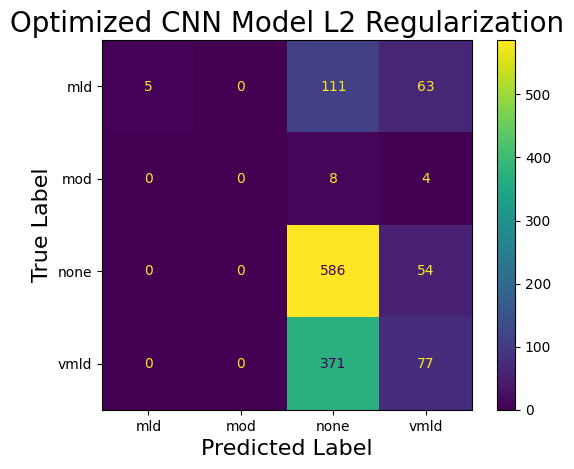

              precision    recall  f1-score   support

        mild       1.00      0.03      0.05       179
    moderate       0.00      0.00      0.00        12
        none       0.54      0.92      0.68       640
   very_mild       0.39      0.17      0.24       448

    accuracy                           0.52      1279
   macro avg       0.48      0.28      0.24      1279
weighted avg       0.55      0.52      0.43      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results_plotter(model_c, res_model_c, fig_name = 'Optimized CNN Model L2 Regularization', report = True)

#### OBSERVATIONS:
This model implementing L2 regularization has performed nearly identically to the previous model.  At this stage, L2 regularization does not appear to be helping to improve the model performance.

# 4 - Overall Observations
* It's unclear if adding multiple addtional convolutional layers to a model betond those in the initial CNN model actually serves to increase performance
* The best model from an accuracy standpoint impletemented class weights
* Additional techniques such as image augmentation, and regualrization appear to adversely impacted model performance